In [19]:
import torch
import torch.nn as nn
import numpy as np
import torchaudio
from torch.utils.data import DataLoader
import torch_audiomentations as t_aug
import os, shutil, math
import time
from datetime import datetime
from itertools import islice
from typing import List
import IPython

from dataset.dcase_dataset import DCASE_SELD_Dataset, InfiniteDataLoader, _get_padders
from evaluation.dcase2022_metrics import cls_compute_seld_results
from evaluation.evaluation_dcase2022 import write_output_format_file, get_accdoa_labels, get_multi_accdoa_labels, determine_similar_location, all_seld_eval
from solver import Solver
from feature import my_feature

import augmentation.spatial_mixup as spm
from augmentation.spliceout import SpliceOut
from parameters import get_parameters
import utils
import plots
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif',
              font_scale=1, color_codes=True, rc={'pcolor.shading': 'auto'})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
utils.seed_everything(1234)

def get_audiomentations(fs=24000):
    from augmentation.spliceout import SpliceOut
    # Initialize augmentation callable
    apply_augmentation = t_aug.Compose(
        transforms=[
            t_aug.Gain(min_gain_in_db=-15.0, max_gain_in_db=5.0, p=0.5, mode='per_example', p_mode='per_example'),
            t_aug.PolarityInversion(p=0.5, mode='per_example', p_mode='per_example'),
            t_aug.PitchShift(p=0.5, min_transpose_semitones=-1.5, max_transpose_semitones=1.5, sample_rate=fs, mode='per_example', p_mode='per_example'),
            t_aug.AddColoredNoise(p=0.5, min_snr_in_db=6.0, max_snr_in_db=30.0, min_f_decay=-2.0, max_f_decay=2.0, sample_rate=fs, mode='per_example', p_mode='per_example'),
            t_aug.BandStopFilter(p=0.5, min_center_frequency=400, max_center_frequency=4000, min_bandwidth_fraction=0.25, max_bandwidth_fraction=1.99, sample_rate=fs, p_mode='per_example'),
            t_aug.LowPassFilter(p=0.5,  min_cutoff_freq=1000, max_cutoff_freq=7500, sample_rate=fs, p_mode='per_example'),
            t_aug.HighPassFilter(p=0.5, min_cutoff_freq=100, max_cutoff_freq=2000, sample_rate=fs, p_mode='per_example'),
            t_aug.BandPassFilter(p=0.5, min_center_frequency=400, max_center_frequency=4000, min_bandwidth_fraction=0.5, max_bandwidth_fraction=1.99, sample_rate=fs, p_mode='per_example'),
            SpliceOut(p=0.5, num_time_intervals=8, max_width=400, sample_rate=fs, p_mode='per_example')
        ]
    )

    return apply_augmentation

In [3]:
config = {
    'dataset_root': './data/data_dcase2022',
    'dataset_list': 'dcase2022_devtrain_debug.txt',
    'dataset_chunk_size': math.floor(10 * 24000),
    'order_output': 1,
    'fs': 24000,
}

dataset = DCASE_SELD_Dataset(directory_root=config['dataset_root'],
                                 list_dataset=config['dataset_list'],
                                 chunk_size=config['dataset_chunk_size'],
                                 chunk_mode='random',
                                 trim_wavs=20,
                                 multi_track=False,
                                 num_classes=13,
                                 labels_backend='sony',
                                 return_fname=False,
                            ignore_labels=True)

audio, _ = dataset[1]


Dataset DCASE_SELD_Dataset
    Number of unique wav files : 2
    Root Location: ./data/data_dcase2022
    List of files: dcase2022_devtrain_debug.txt
    Chunk size: 240000
    Chunk Mode: random
    Trim audio: 20
    Multi_track: False
    Ignore labels: True



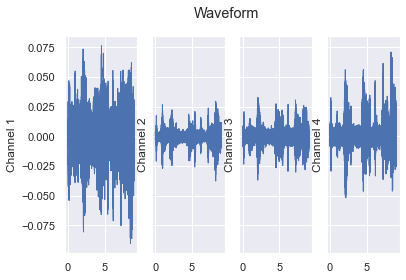

In [4]:
plots.plot_waveform(audio, config['fs'])

signal_in_binaural = utils.sh_sig_to_binaural(audio, order=config['order_output'], 
                                              device='cpu', sofa='data/HRIR_L2354.sofa', do_normalize=False)
IPython.display.display(IPython.display.Audio(signal_in_binaural[0, ...].numpy(), rate=config['fs']))

In [39]:
augment_transform = get_audiomentations()
signal_out_binaural = augment_transform(signal_in_binaural)
IPython.display.display(IPython.display.Audio(signal_out_binaural[0, ...].numpy(), rate=config['fs']))

In [24]:
p, fs = 1, 24000
apply_augmentation = t_aug.Compose(
    transforms=[
        t_aug.Gain(p=p, min_gain_in_db=-15.0, max_gain_in_db=6.0, mode='per_example', p_mode='per_example'),
        t_aug.PolarityInversion(p=p, mode='per_example', p_mode='per_example'),
        #t_aug.PitchShift(p=p, min_transpose_semitones=-3.5, max_transpose_semitones=3.5, sample_rate=fs, mode='per_example', p_mode='per_example'),
        t_aug.AddColoredNoise(p=p, min_snr_in_db=2.0, max_snr_in_db=30.0, min_f_decay=-2.0, max_f_decay=2.0, sample_rate=fs, mode='per_example', p_mode='per_example'),
        #t_aug.BandStopFilter(p=p, min_center_frequency=400, max_center_frequency=4000, min_bandwidth_fraction=0.25, max_bandwidth_fraction=1.99, sample_rate=fs, p_mode='per_example'),
        #t_aug.LowPassFilter(p=p,  min_cutoff_freq=1000, max_cutoff_freq=7500, sample_rate=fs, p_mode='per_example'),
        #t_aug.HighPassFilter(p=p, min_cutoff_freq=100, max_cutoff_freq=2000, sample_rate=fs, p_mode='per_example'),
        #t_aug.BandPassFilter(p=p, min_center_frequency=400, max_center_frequency=4000, min_bandwidth_fraction=0.5, max_bandwidth_fraction=1.99, sample_rate=fs, p_mode='per_example'),
        SpliceOut(p=p, num_time_intervals=8, max_width=400, sample_rate=fs, p_mode='per_example')
    ]
)

class Limiter(nn.Sequential):
    def __init__(self, threshold=1):
        super().__init__()
        self.threshold = threshold
    def forward(self, x):
        mask = torch.abs(x) > self.threshold
        x[mask] = 1.0
        return x

stft = nn.Sequential(
    torchaudio.transforms.Spectrogram(n_fft=1024,
                                 hop_length=240),
    torchaudio.transforms.AmplitudeToDB())

In [25]:
audio_aug = apply_augmentation(audio[None, ...], sample_rate=24000)
limiter = Limiter()
audio_aug = limiter(audio_aug)[0] 
print(audio_aug.shape)
signal_out_binaural = utils.sh_sig_to_binaural(audio_aug, order=config['order_output'], 
                                              device='cpu', sofa='data/HRIR_L2354.sofa', do_normalize=False)
plots.plot_waveform(audio_aug, config['fs'])
#plots.sh_rms_map(audio, INDB=False, title='Input')
#plots.sh_rms_map(audio_aug, INDB=False, title='Augmented')
#plots.plot_specgram_features(stft(audio), sample_rate=fs)
#plots.plot_specgram_features(stft(audio_aug), sample_rate=fs)
IPython.display.display(IPython.display.Audio(signal_out_binaural[0, ...].numpy(), rate=config['fs'], normalize=True))

TypeError: can't assign a ObjectDict to a torch.FloatTensor

In [74]:
signal_out_binaural.shape

torch.Size([1, 2, 216000])